In [462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [463]:
DATA_PATH = r'football_players_dataset.csv'

In [464]:
df = pd.read_csv(DATA_PATH)

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       9680 non-null   object 
 1   player_name                     9680 non-null   object 
 2   age                             9680 non-null   float64
 3   nationality                     9666 non-null   object 
 4   height                          9680 non-null   float64
 5   foot                            6802 non-null   object 
 6   position                        9680 non-null   object 
 7   current_club                    9680 non-null   object 
 8   league                          9680 non-null   object 
 9   appearances                     9680 non-null   int64  
 10  minutes_played                  9680 non-null   int64  
 11  minutes_per_game                9437 non-null   float64
 12  goals                           96

In [466]:
column_descriptions = {
    # ===== THÔNG TIN CƠ BẢN =====
    'player_id': 'ID duy nhất của cầu thủ',
    'player_name': 'Tên cầu thủ',
    'age': 'Tuổi của cầu thủ (năm)',
    'nationality': 'Quốc tịch của cầu thủ',
    'height': 'Chiều cao của cầu thủ (cm)',
    'foot': 'Chân thuận (Left/Right/Both)',
    'position': 'Vị trí thi đấu chính',
    'current_club': 'Câu lạc bộ hiện tại',
    'league': 'Giải đấu hiện tại',

    # ===== THỜI GIAN THI ĐẤU =====
    'minutes_played': 'Tổng số phút thi đấu',
    'minutes_per_game': 'Số phút thi đấu trung bình mỗi trận',

    # ===== CHỈ SỐ TẤN CÔNG =====
    'goals': 'Tổng số bàn thắng',
    'assists': 'Tổng số kiến tạo',
    'goals_per_90': 'Số bàn thắng trung bình mỗi 90 phút',
    'assists_per_90': 'Số kiến tạo trung bình mỗi 90 phút',
    'npg_per90': 'Số bàn thắng không tính penalty mỗi 90 phút',
    'npxg_per90': 'Chỉ số xG không tính penalty mỗi 90 phút',
    'xag_per90': 'Chỉ số kiến tạo kỳ vọng (xAG) mỗi 90 phút',
    'npxg_xag_per90': 'Tổng npxG + xAG mỗi 90 phút',
    'xg_per90': 'Chỉ số bàn thắng kỳ vọng (xG) mỗi 90 phút',
    'shots_per90': 'Số cú sút trung bình mỗi 90 phút',
    'shots_on_target_per90': 'Số cú sút trúng đích mỗi 90 phút',
    'shots_on_target_pct': 'Tỷ lệ sút trúng đích (%)',
    'avg_shot_distance': 'Khoảng cách sút trung bình (m)',
    'sca_per90': 'Số hành động tạo cơ hội dứt điểm mỗi 90 phút',
    'gca_per90': 'Số hành động tạo bàn thắng mỗi 90 phút',

    # ===== CHỈ SỐ CHUYỀN BÓNG – KIẾN TẠO =====
    'key_passes_per90': 'Số đường chuyền tạo cơ hội mỗi 90 phút',
    'passes_completed_per90': 'Số đường chuyền chính xác mỗi 90 phút',
    'pass_completion_pct': 'Tỷ lệ chuyền bóng chính xác (%)',
    'passes_into_final_third_per90': 'Số đường chuyền vào 1/3 cuối sân mỗi 90 phút',
    'passes_into_penalty_area_per90': 'Số đường chuyền vào vòng cấm mỗi 90 phút',
    'progressive_passes_per90': 'Số đường chuyền tịnh tiến mỗi 90 phút',
    'progressive_passes_rec_per90': 'Số lần nhận bóng tịnh tiến mỗi 90 phút',
    'progressive_carries_per90': 'Số lần dẫn bóng tịnh tiến mỗi 90 phút',

    # ===== CHỈ SỐ TRIỂN KHAI BÓNG – RÊ DẮT =====
    'take_ons_per90': 'Số lần rê bóng qua người mỗi 90 phút',
    'take_on_success_pct': 'Tỷ lệ rê bóng thành công (%)',
    'carries_per90': 'Số lần dẫn bóng mỗi 90 phút',
    'carries_into_final_third_per90': 'Số lần dẫn bóng vào 1/3 cuối sân mỗi 90 phút',
    'touches_per90': 'Số lần chạm bóng mỗi 90 phút',
    'touches_att_third_per90': 'Số lần chạm bóng ở 1/3 tấn công mỗi 90 phút',
    'touches_att_pen_per90': 'Số lần chạm bóng trong vòng cấm đối phương mỗi 90 phút',
    'passes_received_per90': 'Số lần nhận đường chuyền mỗi 90 phút',

    # ===== CHỈ SỐ PHÒNG NGỰ =====
    'tackles_per90': 'Số pha tắc bóng mỗi 90 phút',
    'interceptions_per90': 'Số pha cắt bóng mỗi 90 phút',
    'blocks_per90': 'Số pha chắn bóng mỗi 90 phút',
    'ball_recoveries_per90': 'Số lần thu hồi bóng mỗi 90 phút',

    # ===== CHỈ SỐ KHÔNG CHIẾN – THỂ CHẤT =====
    'aerials_won_per90': 'Số pha không chiến thắng mỗi 90 phút',
    'aerial_win_pct': 'Tỷ lệ không chiến thắng (%)',

    # ===== CHỈ SỐ KỶ LUẬT =====
    'yellow_cards_per90': 'Số thẻ vàng mỗi 90 phút',
    'red_cards_per90': 'Số thẻ đỏ mỗi 90 phút',
    'fouls_committed_per90': 'Số lần phạm lỗi mỗi 90 phút',

    # ===== CHỈ SỐ THỦ MÔN – CẢN PHÁ =====
    'goals_against_per90': 'Số bàn thua trung bình mỗi 90 phút',
    'shots_on_target_against_per90': 'Số cú sút trúng đích phải nhận mỗi 90 phút',
    'saves_per90': 'Số pha cứu thua mỗi 90 phút',
    'save_percentage': 'Tỷ lệ cứu thua (%)',
    'clean_sheet_pct': 'Tỷ lệ giữ sạch lưới (%)',
    'psxg_per_shot': 'Chỉ số PSxG trung bình mỗi cú sút phải nhận',
    'psxg_ga_per90': 'PSxG trừ bàn thua mỗi 90 phút',
    'penalty_save_pct': 'Tỷ lệ cản phá penalty (%)',

    # ===== CHỈ SỐ THỦ MÔN – PHÁT BÓNG & CHUYỀN BÓNG =====
    'passes_attempted_per90': 'Số đường chuyền thực hiện mỗi 90 phút',
    'launch_pct': 'Tỷ lệ phát bóng dài (%)',
    'avg_pass_length': 'Độ dài đường chuyền trung bình (m)',

    # ===== CHỈ SỐ THỦ MÔN – QUÉT BÓNG =====
    'def_actions_outside_pen_per90': 'Số pha phòng ngự ngoài vòng cấm mỗi 90 phút',
    'avg_distance_def_actions': 'Khoảng cách trung bình của các pha phòng ngự (m)',

    # ===== CHỈ SỐ THỦ MÔN – CHỐNG BÓNG BỔNG =====
    'crosses_stopped_pct': 'Tỷ lệ cản phá bóng bổng từ tạt cánh (%)',

    # ===== CHỈ SỐ KẾT QUẢ TRẬN ĐẤU =====
    'wins_per90': 'Số trận thắng trung bình mỗi 90 phút',
    'draws_per90': 'Số trận hòa trung bình mỗi 90 phút',
    'losses_per90': 'Số trận thua trung bình mỗi 90 phút',

    # ===== GIÁ TRỊ THỊ TRƯỜNG (TARGET) =====
    'market_value': 'Giá trị thị trường ước tính của cầu thủ (EUR)'
}


In [467]:
df.drop(columns=['player_id'], inplace=True)

In [468]:
df.position.unique()

array(['FW', 'FW-MF', 'MF', 'DF', 'DF-MF', 'DF-FW', 'GK', 'DF-FW-MF'],
      dtype=object)

In [469]:
df[df.minutes_per_game.isna()]

,player_name,age,nationality,height,foot,position,current_club,league,appearances,minutes_played,minutes_per_game,goals,assists,goals_per_90,assists_per_90,npg_per90,npxg_per90,xag_per90,npxg_xag_per90,xg_per90,shots_per90,shots_on_target_per90,shots_on_target_pct,avg_shot_distance,sca_per90,gca_per90,key_passes_per90,passes_completed_per90,pass_completion_pct,passes_into_final_third_per90,passes_into_penalty_area_per90,progressive_passes_per90,progressive_passes_rec_per90,progressive_carries_per90,take_ons_per90,take_on_success_pct,carries_per90,carries_into_final_third_per90,touches_per90,touches_att_third_per90,touches_att_pen_per90,passes_received_per90,tackles_per90,interceptions_per90,blocks_per90,ball_recoveries_per90,aerials_won_per90,aerial_win_pct,yellow_cards_per90,red_cards_per90,fouls_committed_per90,goals_against_per90,shots_on_target_against_per90,saves_per90,save_percentage,clean_sheet_pct,psxg_per_shot,psxg_ga_per90,penalty_save_pct,passes_attempted_per90,launch_pct,avg_pass_length,def_actions_outside_pen_per90,avg_distance_def_actions,crosses_stopped_pct,wins_per90,draws_per90,losses_per90,market_value
197,Elías Ocampo,21.0,Argentina,167.0,NaN,MF,Rosario Central,Argentine Liga,0,0,NaN,0,0,0.00,0.20,0.00,0.00,0.08,0.08,0.00,0.59,0.20,33.3,28.0,1.37,0.59,0.20,19.76,74.3,1.57,0.20,2.15,2.93,2.35,1.57,40.0,20.15,1.37,42.85,10.76,0.98,20.15,2.93,0.78,1.76,6.85,0.98,38.5,0.00,0.00,1.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200
226,Cristian Lema,35.0,Argentina,190.0,Right,DF,Boca Juniors,Argentine Liga,0,0,NaN,0,0,0.11,0.00,0.11,0.04,0.02,0.08,0.04,1.11,0.33,30.0,19.1,0.78,0.00,0.11,42.10,77.9,3.23,0.00,3.79,0.33,0.67,0.11,33.3,31.41,0.33,66.50,4.12,1.34,38.87,2.01,1.56,0.89,4.34,5.12,79.3,0.67,0.11,1.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125
257,Luciano Sánchez,31.0,Argentina,169.0,NaN,DF,Arg Juniors,Argentine Liga,0,0,NaN,0,0,0.00,0.00,0.00,0.02,0.11,0.13,0.02,0.32,0.00,0.0,20.5,1.37,0.11,0.63,42.10,77.8,4.75,1.27,5.28,3.80,0.74,0.63,66.7,29.33,1.27,64.47,12.13,0.74,34.71,2.74,1.16,1.58,5.70,1.37,44.8,0.21,0.00,1.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125
258,Thiago Santamaría,22.0,Argentina,175.0,NaN,DF,Arg Juniors,Argentine Liga,0,0,NaN,0,0,0.00,0.00,0.00,0.03,0.08,0.11,0.03,0.94,0.31,33.3,25.8,2.50,0.31,0.78,28.86,69.8,3.59,1.40,3.90,4.84,2.18,0.47,50.0,28.86,0.47,54.44,13.73,1.09,30.73,2.96,1.40,0.94,3.59,0.62,36.4,0.00,0.00,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
294,Federico Gattoni,26.0,Argentina,183.0,NaN,DF,River Plate,Argentine Liga,0,0,NaN,0,0,0.05,0.05,0.05,0.13,0.04,0.17,0.13,0.89,0.26,29.4,10.6,0.47,0.16,0.16,35.05,88.3,1.05,0.00,1.63,0.11,0.26,0.11,40.0,28.05,0.05,47.95,1.42,1.16,30.00,1.16,0.74,0.95,6.21,1.95,56.1,0.21,0.00,0.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9289,Leandro Maciel,29.0,Argentina,179.0,NaN,MF,Botafogo (SP),Série B,0,0,NaN,0,0,0.22,0.05,0.22,0.16,0.06,0.23,0.16,2.25,0.71,31.7,22.6,2.20,0.05,1.10,25.09,74.1,3.24,0.38,4.12,2.42,0.60,0.44,66.7,19.60,0.77,45.47,10.87,1.26,25.37,2.20,1.04,1.32,7.41,1.04,38.0,0.05,0.00,1.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600
9335,Lima,26.0,Brazil,174.0,Left,MF,Guarani,Série B,0,0,NaN,0,0,0.00,0.12,0.00,0.07,0.12,0.19,0.07,0.84,0.24,28.6,21.1,2.16,0.06,1.08,28.68,72.7,3.13,0.42,3.49,3.31,1.38,0.30,31.3,28.32,1.08,49.42,13.23,1.14,30.78,1.56,0.78,1.44,4.39,0.30,25.0,0.18,0.00,1.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.000
9490,Arnaud Lusamba,25.0,Congo DR,179.0,Right,MF,Alanyaspor,Süper Lig,0,0,NaN,0,0,0.09,0.18,0.09,0.04,0.14,0.18,0.0

In [470]:
df['minutes_per_game'] = df['minutes_per_game'].fillna(0)

In [471]:
df['age_group'] = pd.cut(df['age'], bins=[15,23,30,34,50], labels=False)
df['height_group'] = pd.cut(df['height'], bins=5, labels=False)

In [472]:
df['goals_x_assists'] = df['goals'] * df['assists']
df['age_height'] = df['age'] * df['height']
df['xg_per_shot'] = df['xg_per90'] / (df['shots_per90'] + 1e-6)
df['goals_per_shot'] = df['goals'] / (df['shots_per90'] + 1e-6)
df['assists_per_takeon'] = df['assists'] / (df['take_ons_per90'] + 1e-6)

In [473]:
info_columns = ['age_group', 'height_group', 'age_height', 'nationality', 'foot', 'current_club', 'league']
target = 'market_value'

In [474]:
fw_players = df[df['position'].isin(['FW', 'FW-MF'])].copy().reset_index(drop = True)
mf_players = df[df['position'].isin(['MF'])].copy().reset_index(drop = True)
df_players = df[df['position'].isin(['DF', 'DF-MF', 'DF-FW', 'DF-FW-MF'])].copy().reset_index(drop = True)
gk_players = df[df['position'].isin(['GK'])].copy().reset_index(drop = True)

In [475]:
fw_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 76 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_name                     3071 non-null   object 
 1   age                             3071 non-null   float64
 2   nationality                     3068 non-null   object 
 3   height                          3071 non-null   float64
 4   foot                            2260 non-null   object 
 5   position                        3071 non-null   object 
 6   current_club                    3071 non-null   object 
 7   league                          3071 non-null   object 
 8   appearances                     3071 non-null   int64  
 9   minutes_played                  3071 non-null   int64  
 10  minutes_per_game                3071 non-null   float64
 11  goals                           3071 non-null   int64  
 12  assists                         30

In [476]:
fw_cols = [
    
    'goals', 'goals_per_90', 'npg_per90', 'goals_x_assists', 'goals_per_shot', 
    
    'shots_per90', 'shots_on_target_per90', 'shots_on_target_pct',
    'avg_shot_distance', 'xg_per_shot',

    'assists', 'assists_per_90', 'xag_per90', 'npxg_xag_per90','assists_per_takeon',
    'sca_per90', 'gca_per90',

    'take_ons_per90',
    'take_on_success_pct',
    'carries_per90',
    'carries_into_final_third_per90',

    'touches_att_pen_per90',
    'touches_att_third_per90',

    'aerials_won_per90', 'aerial_win_pct'
    ]

fw_cols = info_columns + fw_cols  + [target]

In [477]:
mf_cols = [

    # Phòng ngự
    'tackles_per90', 'interceptions_per90',
    'ball_recoveries_per90', 'blocks_per90',

    # Phân phối & build-up
    'passes_completed_per90', 'pass_completion_pct',
    'progressive_passes_per90',
    'passes_into_final_third_per90',

    # Di chuyển & kiểm soát
    'touches_per90', 'passes_received_per90',
    'progressive_carries_per90',
    'carries_into_final_third_per90',

    # Sáng tạo
    'key_passes_per90', 'xag_per90',
    'sca_per90', 'gca_per90',

    # Tấn công bổ trợ
    'assists', 'shots_per90', 'npxg_per90',

    # Kỷ luật
    'yellow_cards_per90',
    'red_cards_per90',
    'fouls_committed_per90',
]

mf_cols = info_columns + mf_cols + [target]

In [478]:
df_cols = [

     # Phòng ngự
    'tackles_per90', 'interceptions_per90',
    'blocks_per90', 'ball_recoveries_per90',

    # Không chiến
    'aerials_won_per90', 'aerial_win_pct',

    # Build-up
    'passes_completed_per90', 'pass_completion_pct',
    'progressive_passes_per90',
    'passes_into_final_third_per90',

    # Hỗ trợ tấn công (FB/WB)
    'progressive_carries_per90',
    'carries_into_final_third_per90',
    'key_passes_per90',
    'xag_per90',

    # Kỷ luật
    'fouls_committed_per90',
    'yellow_cards_per90', 'red_cards_per90'
]

df_cols = info_columns + df_cols + [target]

In [479]:
gk_cols = [

     # ===== CHỈ SỐ THỦ MÔN – CẢN PHÁ =====
    'goals_against_per90',
    'shots_on_target_against_per90',
    'saves_per90',
    'save_percentage'
    'clean_sheet_pct',
    'psxg_per_shot',
    'psxg_ga_per90',
    'penalty_save_pct',

    # ===== CHỈ SỐ THỦ MÔN – PHÁT BÓNG & CHUYỀN BÓNG =====
    'passes_attempted_per90',
    'launch_pct',
    'avg_pass_length',

    # ===== CHỈ SỐ THỦ MÔN – QUÉT BÓNG =====
    'def_actions_outside_pen_per90',
    'avg_distance_def_actions',

    # ===== CHỈ SỐ THỦ MÔN – CHỐNG BÓNG BỔNG =====
    'crosses_stopped_pct',

    # ===== CHỈ SỐ KẾT QUẢ TRẬN ĐẤU =====
    'wins_per90',
    'draws_per90',
    'losses_per90',
]

gk_cols = info_columns + gk_cols + [target]

In [480]:
fw_players_feature_selected = fw_players[fw_cols].copy()

In [481]:
fw_players_feature_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age_group                       3071 non-null   int64  
 1   height_group                    3071 non-null   int64  
 2   age_height                      3071 non-null   float64
 3   nationality                     3068 non-null   object 
 4   foot                            2260 non-null   object 
 5   current_club                    3071 non-null   object 
 6   league                          3071 non-null   object 
 7   goals                           3071 non-null   int64  
 8   goals_per_90                    3071 non-null   float64
 9   npg_per90                       3071 non-null   float64
 10  goals_x_assists                 3071 non-null   int64  
 11  goals_per_shot                  3071 non-null   float64
 12  shots_per90                     30

In [482]:
fw_players_feature_selected.describe().T

,count,mean,std,min,25%,50%,75%,max
age_group,3071.0,1.180397,0.803506,0.00,1.000000,1.000000,2.000000,3.000000e+00
height_group,3071.0,2.015630,0.710381,0.00,2.000000,2.000000,2.000000,4.000000e+00
age_height,3071.0,5000.185282,818.486533,2848.00,4416.000000,4950.000000,5550.000000,8.106000e+03
goals,3071.0,4.043308,4.578780,0.00,1.000000,3.000000,6.000000,3.900000e+01
goals_per_90,3071.0,0.302960,0.230431,0.00,0.150000,0.260000,0.410000,2.430000e+00
npg_per90,3071.0,0.220840,0.195497,0.00,0.070000,0.190000,0.330000,1.890000e+00
goals_x_assists,3071.0,13.670140,29.948821,0.00,0.000000,3.000000,14.000000,5.220000e+02
goals_per_shot,3071.0,2.013497,2.335569,0.00,0.386100,1.302931,2.941171,2.666661e+01
shots_per90,3071.0,2.131407,0.849183,0.00,1.550000,2.080000,2.620000,7.310000e+00
shots_on_target_per90,3071.0,0.756763,0.405958,0.00,0.475000,0.720000,0.980000,4.110000e+00


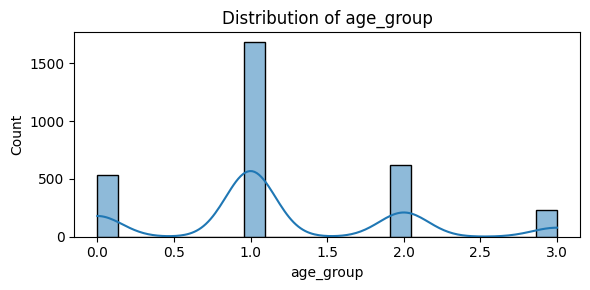

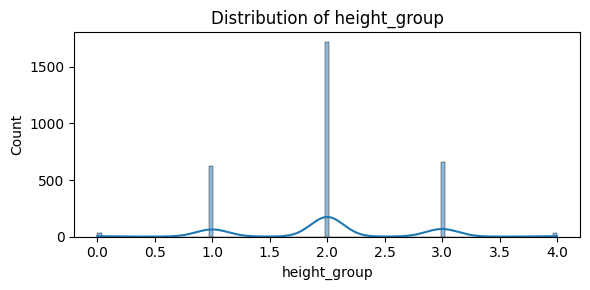

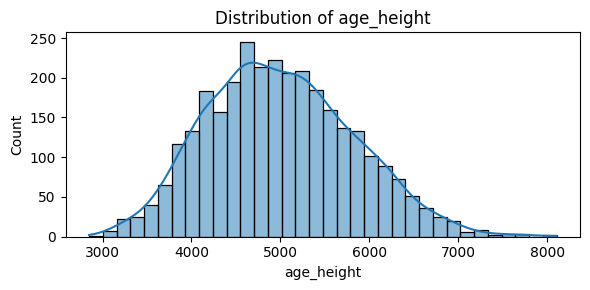

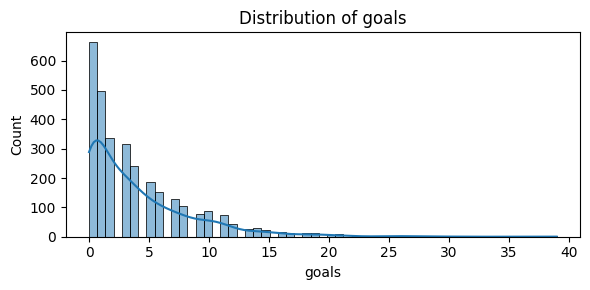

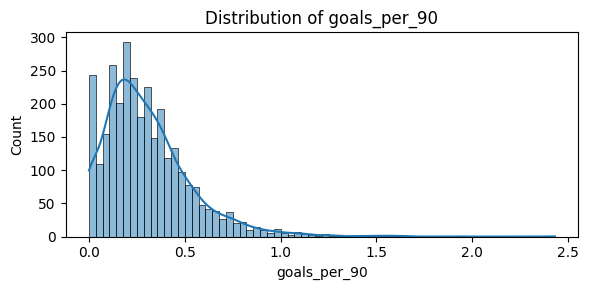

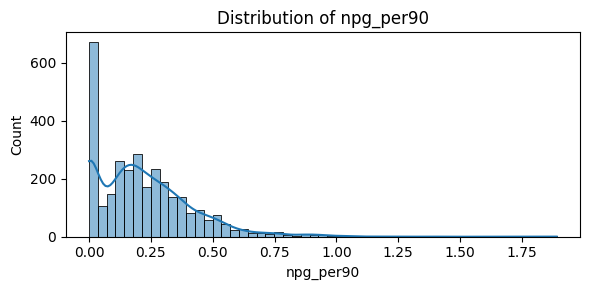

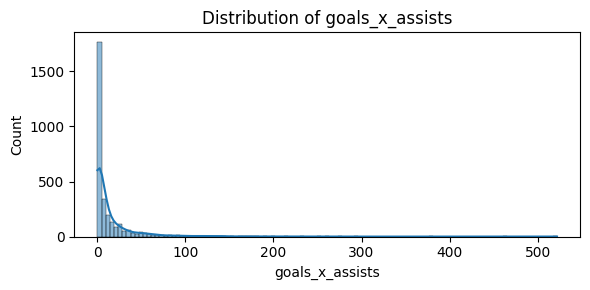

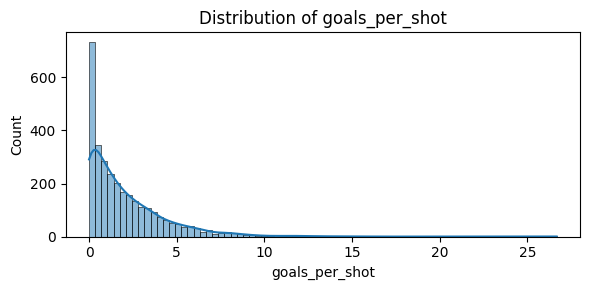

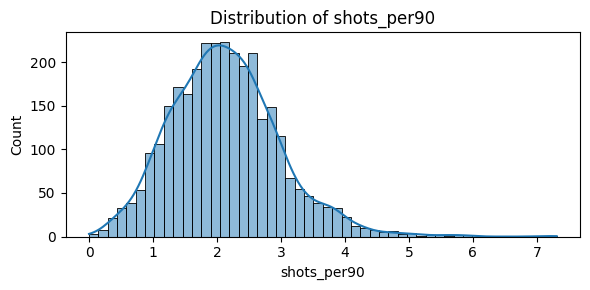

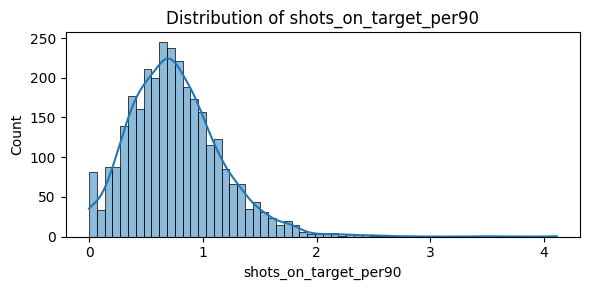

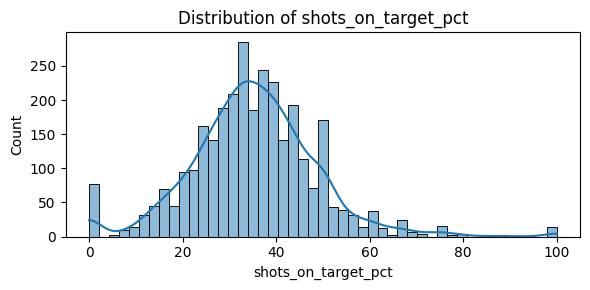

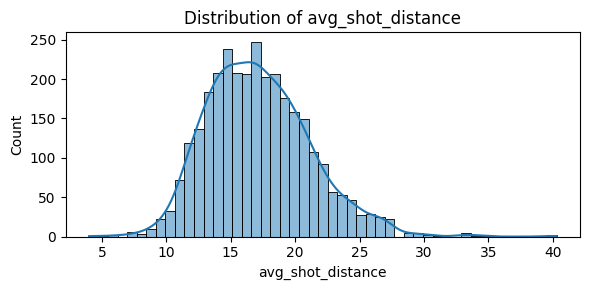

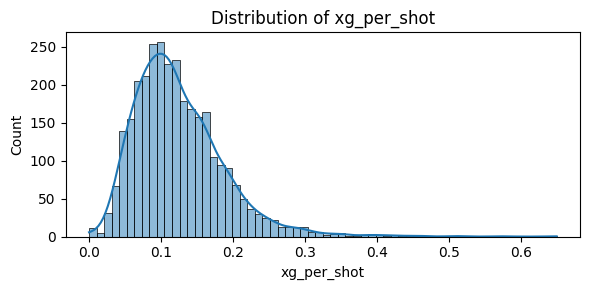

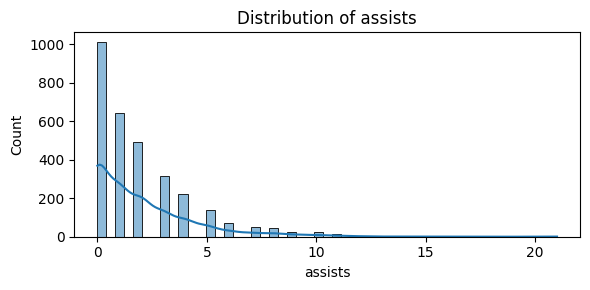

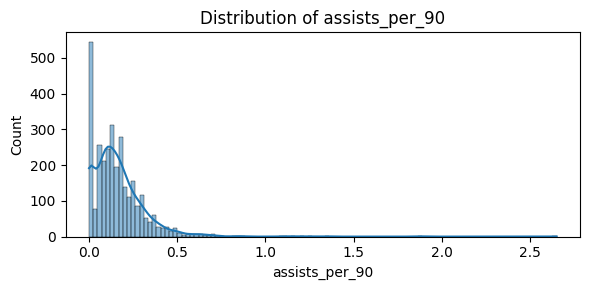

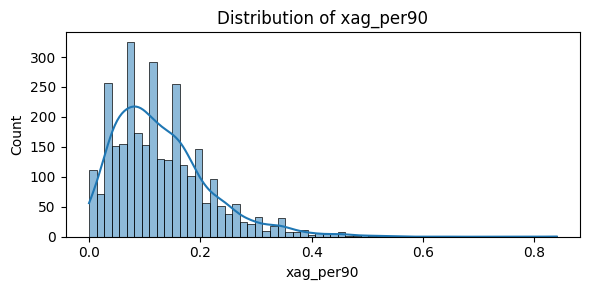

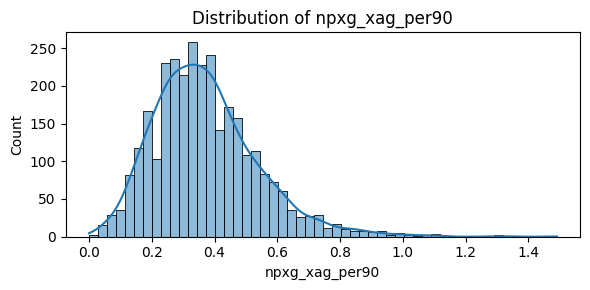

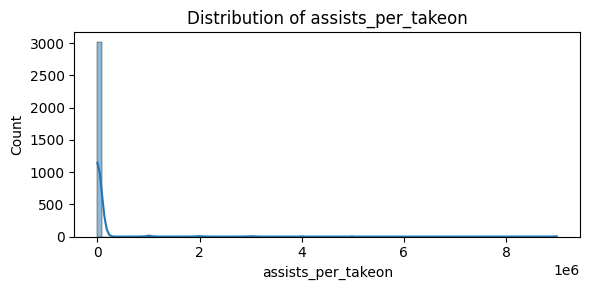

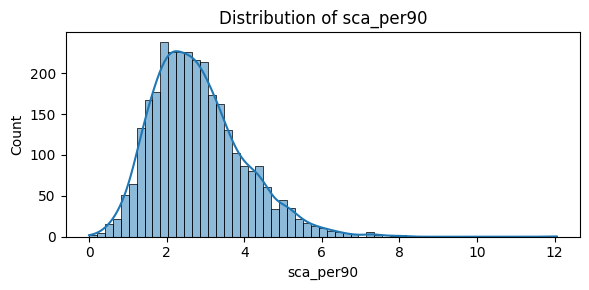

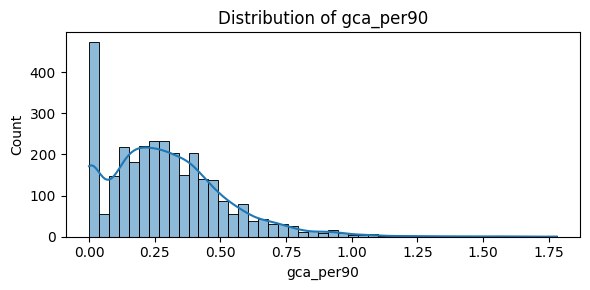

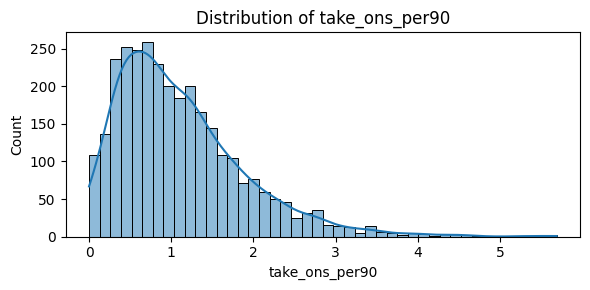

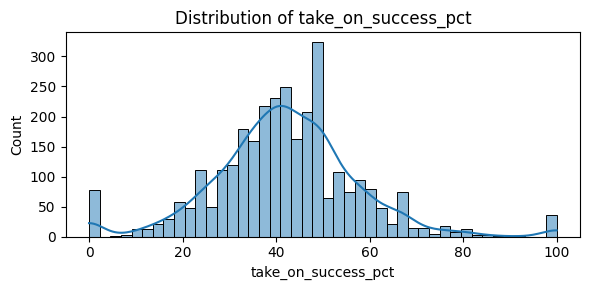

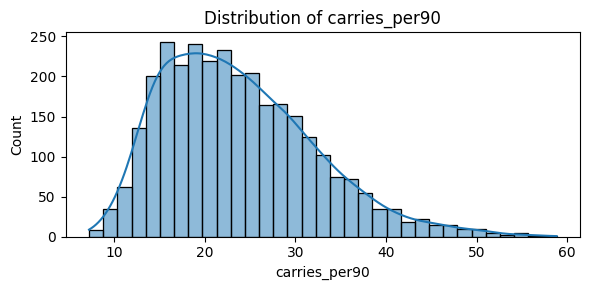

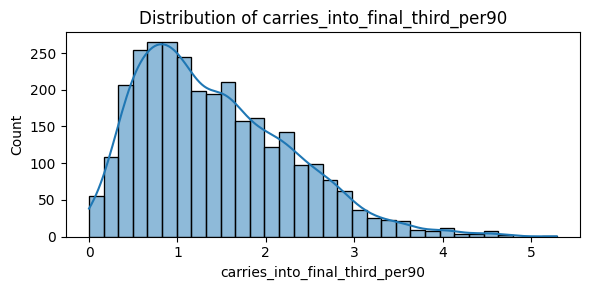

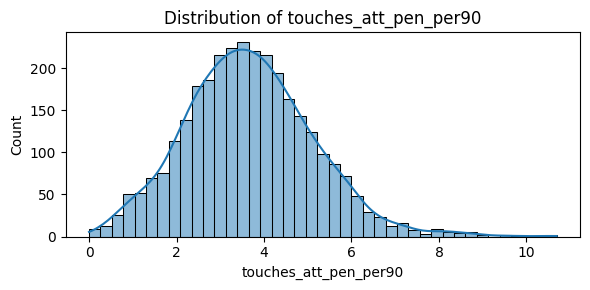

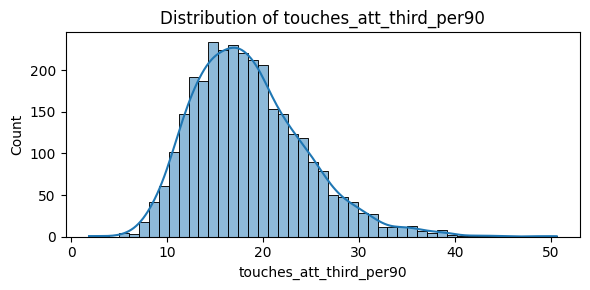

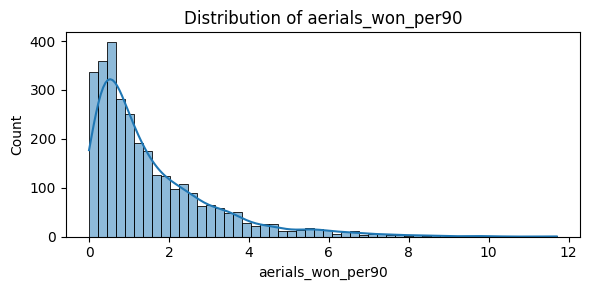

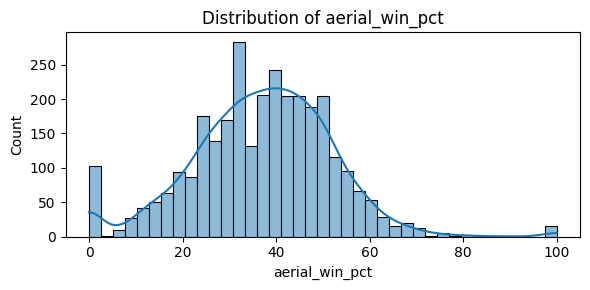

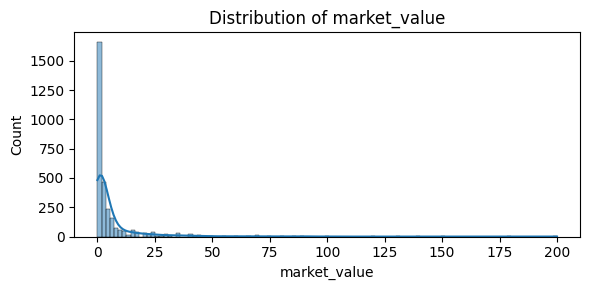

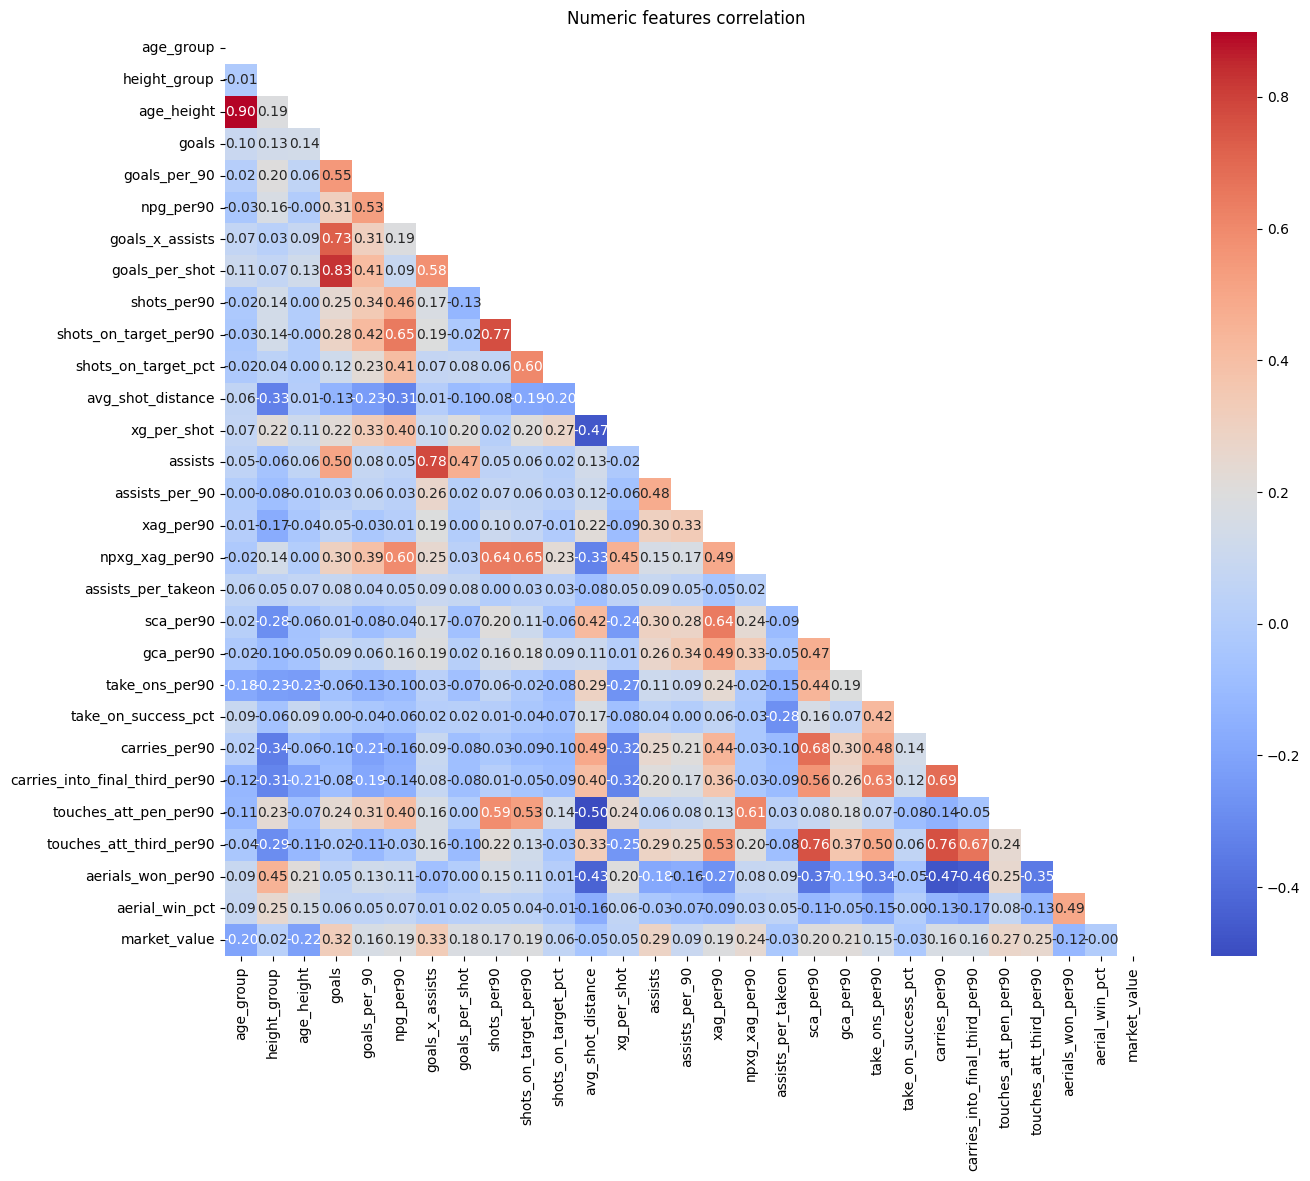

In [483]:
num_cols = fw_players_feature_selected.select_dtypes(include=[np.number]).columns.tolist()


for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(fw_players_feature_selected[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()

corr = fw_players_feature_selected[num_cols].corr()

# Tạo mask tam giác trên
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)
plt.title('Numeric features correlation')
plt.show()

In [484]:
fw_players_feature_selected['log_goals_x_assists'] = np.log1p(fw_players_feature_selected['goals_x_assists']) 
fw_players_feature_selected['log_assists_per_takeon'] = np.log1p(fw_players_feature_selected['assists_per_takeon']) 

In [485]:
X_fw = fw_players_feature_selected.drop(columns=[target,'goals_x_assists', 'assists_per_takeon'], axis=1)
y_fw = fw_players_feature_selected[target]

In [486]:
bins = pd.qcut(y_fw, q=10, labels=False, duplicates='drop')
X_fw_train, X_fw_test, y_fw_train, y_fw_test = train_test_split(X_fw, y_fw, test_size = 0.2, random_state=42, stratify=bins)

<Axes: >

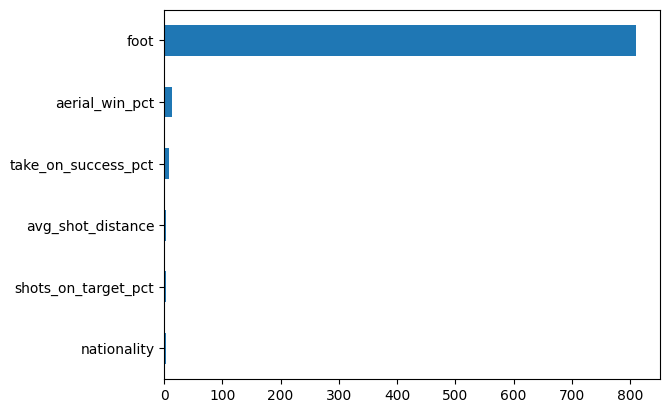

In [487]:
fw_missing = fw_players_feature_selected.isna().sum()
fw_missing= fw_missing[fw_missing > 0].sort_values()

fw_missing.plot(kind='barh')

In [488]:
num_cols = X_fw_train.select_dtypes(include=[np.number]).columns.tolist()

In [489]:
cat_cols = X_fw_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [490]:
foot_missing_fill = X_fw_train['foot'].mode()[0]
X_fw_train['foot'] = X_fw_train['foot'].fillna(foot_missing_fill)
X_fw_test['foot'] = X_fw_test['foot'].fillna(foot_missing_fill)

In [491]:
nationality_missing_fill = X_fw_train['nationality'].mode()[0]
X_fw_train['nationality'] = X_fw_train['nationality'].fillna(nationality_missing_fill)
X_fw_test['nationality'] = X_fw_test['nationality'].fillna(nationality_missing_fill)

In [492]:
imputer = SimpleImputer(strategy='mean')
X_fw_train[num_cols] = imputer.fit_transform(X_fw_train[num_cols])
X_fw_test[num_cols] = imputer.transform(X_fw_test[num_cols])

In [493]:
X_fw_train[X_fw_train.isna().any(axis=1)]


,age_group,height_group,age_height,nationality,foot,current_club,league,goals,goals_per_90,npg_per90,goals_per_shot,shots_per90,shots_on_target_per90,shots_on_target_pct,avg_shot_distance,xg_per_shot,assists,assists_per_90,xag_per90,npxg_xag_per90,sca_per90,gca_per90,take_ons_per90,take_on_success_pct,carries_per90,carries_into_final_third_per90,touches_att_pen_per90,touches_att_third_per90,aerials_won_per90,aerial_win_pct,log_goals_x_assists,log_assists_per_takeon


In [494]:
X_fw_train = pd.get_dummies(X_fw_train, columns=cat_cols, drop_first=True)
X_fw_test = pd.get_dummies(X_fw_test, columns=cat_cols, drop_first=True)
X_fw_test = X_fw_test.reindex(columns=X_fw_train.columns, fill_value=0)

In [495]:
y_fw_train_log = np.log1p(y_fw_train)
y_fw_test_log = np.log1p(y_fw_test)

In [496]:
gb_model = GradientBoostingRegressor(random_state=42)

In [497]:
gb_model.fit(X_fw_train, y_fw_train_log)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [498]:
y_fw_pred_log = gb_model.predict(X_fw_test)
y_fw_pred = np.expm1(y_fw_pred_log)
mae = mean_absolute_error(y_fw_test, y_fw_pred)
rmse = root_mean_squared_error(y_fw_test, y_fw_pred)
r2 = r2_score(y_fw_test, y_fw_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 4.4048
RMSE: 13.4446
r2_score: 0.5060


In [499]:
param_dist = {
    'n_estimators': randint(200, 600),
    'learning_rate': uniform(0.03, 0.1),
    'max_depth': randint(2, 4),
    'min_samples_leaf': randint(10, 40),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', None]
}

In [500]:
bins = pd.qcut(y_fw_train, q=10, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [501]:
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=50,        # <= quan trọng
    cv=3,             # 3-fold là đủ
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [502]:
random_search.fit(X_fw_train, y_fw_train_log)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': <scipy.stats....002353F100EB0>, 'max_depth': <scipy.stats....00235366046E0>, 'max_features': ['sqrt', None], 'min_samples_leaf': <scipy.stats....002353EEEACF0>, ...}"
,n_iter,50
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [503]:
best_model = random_search.best_estimator_

In [504]:
y_fw_test_pred_log = best_model.predict(X_fw_test)
y_fw_test_pred = np.expm1(y_fw_test_pred_log)

In [505]:
mae = mean_absolute_error(y_fw_test, y_fw_test_pred)
rmse = root_mean_squared_error(y_fw_test, y_fw_test_pred)
r2 = r2_score(y_fw_test, y_fw_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 3.7865
RMSE: 10.9513
r2_score: 0.5060


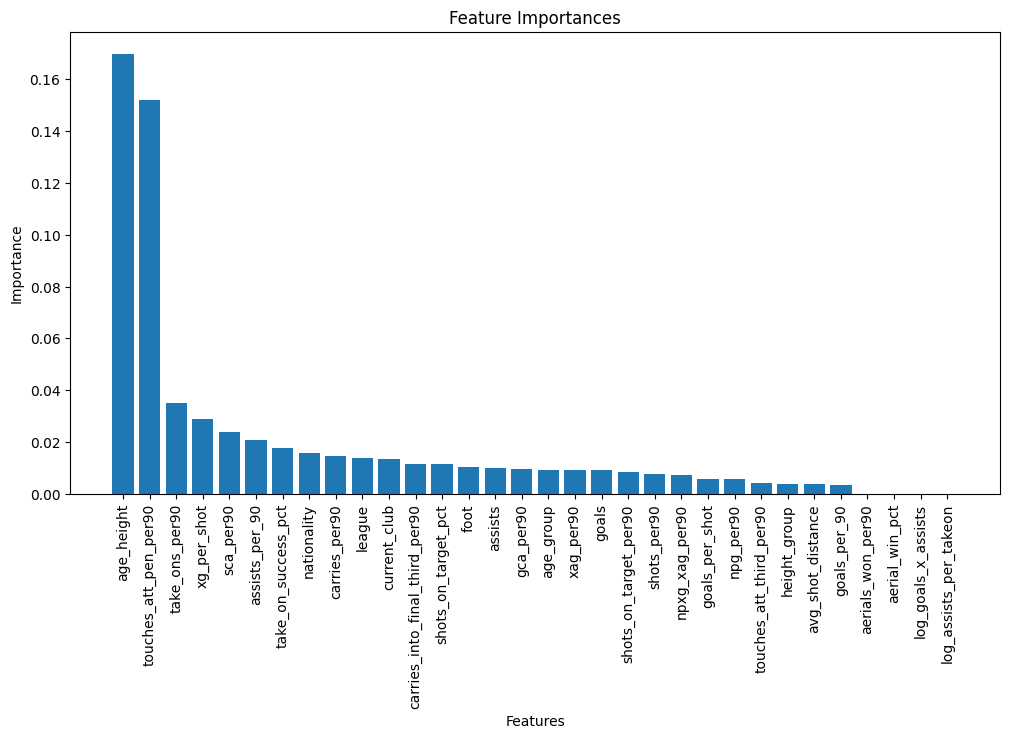

In [506]:
features, importances = zip(*sorted(
    zip(X_fw.columns, best_model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
))

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()